# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Задача:** Построить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
!pip install sweetviz
import sweetviz as sv

In [3]:
df = pd.read_csv('autos.csv')

In [4]:
display (df.head(5))
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Из документации к данным нам известно:

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля 
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

### Предобработка данных

Удалим неинформативные признаки `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` - не пригодятся для обучения модели.

In [5]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode'], axis=1)

**Заполним пропуски**

In [6]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
LastSeen                 0
dtype: int64

In [7]:
# заполним пропуски в столбце модели машины на наименование бренда авто
df.loc[df['Model'].isna() == True, 'Model'] = df['Brand']

In [8]:
# удалим строки, где есть пропуски в столбцах VehicleType, Gearbox, FuelType, так как они менее информативны
df = df.drop(np.where((df['VehicleType'].isna() == True) & (df['Gearbox'].isna() == True) 
                      & (df['FuelType'].isna() == True))[0])

In [9]:
display (df['FuelType'].value_counts())
display (df['VehicleType'].value_counts())
display (df['Gearbox'].value_counts())

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [10]:
# пропуски в типе кузова вынесем в категорию "другое"
df['VehicleType'].fillna('other', inplace=True)

# пропуски в типе топлива заменим самым частым значением
df['FuelType'].fillna('petrol', inplace=True)

# пропуски в типе КП удалим
df.dropna(subset = ['Gearbox'], axis=0, inplace=True)


<AxesSubplot:>

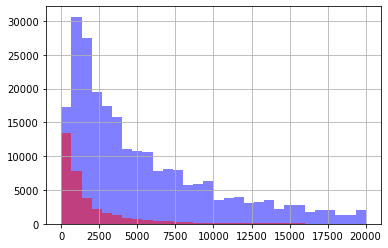

In [11]:
NotRepaired = df.loc[df['NotRepaired'] == 'no', 'Price']
Repaired = df.loc[df['NotRepaired'] == 'yes', 'Price']

NotRepaired.hist(bins=30, alpha=0.5, color='b')
Repaired.hist(bins=30, alpha=0.5, color='r')

На графике можно проследить, что если цена авто больше 5000 евро, то скорее всего машина не была в ремонте.

In [12]:
df.loc[(df['NotRepaired'].isna() == True) & (df['Price'] > 5000), 'NotRepaired'] = 'no'

In [13]:
# остальные пропуски заменим 'none'
df['NotRepaired'].fillna('none', inplace=True)

**Обработка аномалий**

In [14]:
#report = sv.analyze([df, "autos"])

In [15]:
#report.show_html('common analysis.html')

[Text(0.5, 1.0, 'Пробег(км)')]

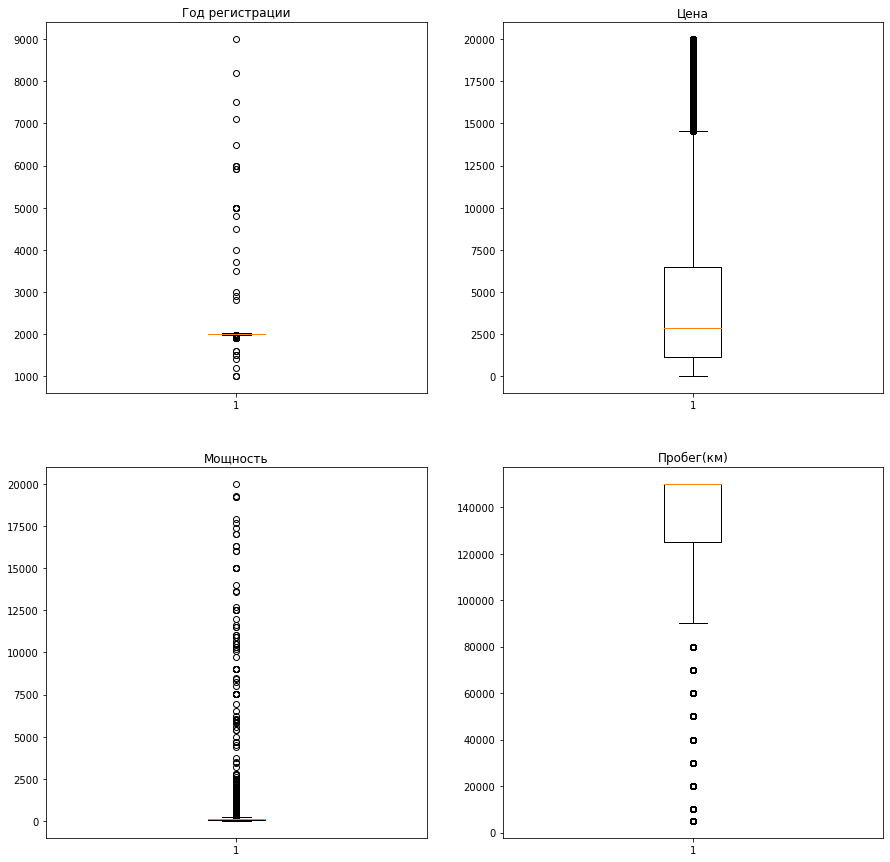

In [16]:
fig = plt.figure(figsize=(15, 15))

ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)
ax_3 = fig.add_subplot(2, 2, 3)
ax_4 = fig.add_subplot(2, 2, 4)

ax_1.boxplot(df['RegistrationYear'])
ax_2.boxplot(df['Price'])
ax_3.boxplot(df['Power'])
ax_4.boxplot(df['Kilometer'])

ax_1.set(title='Год регистрации')
ax_2.set(title='Цена')
ax_3.set(title='Мощность')
ax_4.set(title='Пробег(км)')

In [17]:
display (df['Price'].describe())
df[df['Price'] < 1].head()

count    334536.000000
mean       4547.697291
std        4551.131380
min           0.000000
25%        1150.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,LastSeen
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-25 16:47:58
111,0,other,2017,manual,0,golf,5000,12,petrol,volkswagen,none,2016-04-01 08:47:05
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-12 23:47:10
231,0,wagon,2001,manual,115,mondeo,150000,0,petrol,ford,none,2016-03-26 11:17:50
466,0,other,2016,auto,197,3er,150000,12,gasoline,bmw,no,2016-03-25 19:46:09


In [18]:
df['LastSeen'].max()

'2016-04-07 14:58:51'

В данных замечены следующие аномалии:
* Если судить по дате выгрузки базы, или дате последней активности пользователя, то год регистрации не может быть больше 2016 года
* Мощность автомобилей превышает 1000 л.с.
* Цена автомобилей не указана

In [19]:
# удалим аномалии
df = df[(df['RegistrationYear'] > 1960) & (df['RegistrationYear'] < 2016)]
df = df[(df['Power'] < 1000)]
df = df[df['Price'] > 150]
df = df.drop(['LastSeen'], axis=1)

**Подготовка признаков**

Подготовим отдельный датасет с численными признаками для моделей, которые не обучаются на категориальных данных.

In [20]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,none
1,18300,coupe,2011,manual,190,audi,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


В датасете 6 категориальных признаков. Закодируем их в численные признаки техникой прямого и порядкового кодирования.

In [21]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [22]:
encoder = OrdinalEncoder()
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

df[category] = encoder.fit_transform(df[category])

In [23]:
display (df_ohe.head(), df.head())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_none,NotRepaired_yes
0,480,1993,0,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,3.0,1993,1.0,0,127.0,150000,0,6.0,38.0,1.0
1,18300,2.0,2011,1.0,190,44.0,125000,5,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163,128.0,125000,8,2.0,14.0,0.0
3,1500,5.0,2001,1.0,75,127.0,150000,6,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,110.0,90000,7,2.0,31.0,0.0


**Разделение выборки**

In [24]:
#разделим данные на валидационную, тестовую и тренировочную выборки: 20%, 20% и 60% соответственно
features = df.drop('Price', axis=1)
target = df['Price']


features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(
    df, target = 'Price', train_size=0.6, valid_size=0.2, test_size=0.2)

print (features_train.shape, features_valid.shape, features_test.shape)

features_ohe = df_ohe.drop('Price', axis=1)
target_ohe = df_ohe['Price']


features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe, features_test_ohe, target_test_ohe = (
    train_valid_test_split(df_ohe, target = 'Price', train_size=0.6, valid_size=0.2, test_size=0.2))

print (features_train_ohe.shape, features_valid_ohe.shape, features_test_ohe.shape)

(181345, 10) (60448, 10) (60449, 10)
(181345, 348) (60448, 348) (60449, 348)


**Масштабирование признаков**

Стандартизируем численные признаки датасета.

In [25]:
def scaler(features_train, features_valid, features_test):
    numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
    
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test

features_train, features_valid, features_test = scaler(features_train, features_valid, features_test)
features_train_ohe, features_valid_ohe, features_test_ohe = scaler(
    features_train_ohe, features_valid_ohe, features_test_ohe)

**Вывод:**

Данные загружены и подготовлены:
* Удалены неинформативные признаки
* Заполненые пропуски в столбцах: тип кузова, тип КП, модель, тип топлива, ремонт машины
* Обработаны аномалии
* Данные разделены на выборки и подготовлены к обучению моделей

## Обучение моделей

Обучим несколько моделей: случайный лес, линейную регрессию и градиентный бустинг, нам важны следующие критерии:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

**Модель случайного леса**

In [26]:
%%time

# features_train, target_train, features_valid, target_valid, features_test, target_test

best_forest_model = ''
best_forest_result = 10000
for depth in range(1, 20, 2):
    model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=10)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
        
    rmse = mean_squared_error(target_valid, prediction) ** 0.5
        
    if rmse < best_forest_result:
        best_forest_result = rmse
        best_forest_model = model
            
print ('Лучший результат случайного леса: ', round(best_forest_result))
print ('Лучшая модель случайного леса: ', best_forest_model)

Лучший результат случайного леса:  1593
Лучшая модель случайного леса:  RandomForestRegressor(max_depth=17, n_estimators=10, random_state=12345)
Wall time: 38.7 s


**Линейная регрессия**

In [27]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression.fit(features_train_ohe, target_train_ohe)
prediction = linear_regression.predict(features_valid_ohe)
print('RMSE линейной регрессии', round(mean_squared_error(target_valid_ohe, prediction) ** 0.5))

RMSE линейной регрессии 2581


**Градиентный бустинг**

In [28]:
%%time

trees = [1000]
best_gbm_model = ''
best_gbm_result = 10000

for tree in trees:
    gbm_model= LGBMRegressor(n_estimators=tree, max_depth=8, num_leaves=200)
    gbm_model.fit(features_train, target_train)
        
    prediction = gbm_model.predict(features_valid)
    rmse = mean_squared_error(target_valid, prediction) ** 0.5
        
    if rmse < best_gbm_result:
        best_gbm_result = rmse
        best_gbm_model = gbm_model

print('Лучший RMSE градиентного бустинга: ', round(best_gbm_result))
print ('Лучшая модель градиентного бустинга: ', best_gbm_model)

Лучший RMSE градиентного бустинга:  1487
Лучшая модель градиентного бустинга:  LGBMRegressor(max_depth=8, n_estimators=1000, num_leaves=200)
Wall time: 19.2 s


## Анализ моделей

Нам необходимо проанализировать следующие параметры:
* Время обучения модели
* Время предсказания модели
* Качество предсказания

**Проанализируем, сколько времени необходимо на обучение каждой модели.**

In [31]:
%%time

best_forest_model.fit(features_train, target_train)

Wall time: 6.43 s


RandomForestRegressor(max_depth=17, n_estimators=10, random_state=12345)

In [32]:
%%time

linear_regression.fit(features_train, target_train)

Wall time: 246 ms


LinearRegression()

In [33]:
%%time

best_gbm_model.fit(features_train, target_train)

Wall time: 15 s


LGBMRegressor(max_depth=8, n_estimators=1000, num_leaves=200)

Время обучения моделей:
* Случайный лес обучается за 28 секунд
* Линейная регрессия - меньше, чем за 1 секунду
* Градиентный бустинг - 24 секунды

**Посмотрим на время, за которое модели делают предсказания.**

In [34]:
%%time

predictions_forest = best_forest_model.predict(features_valid)

Wall time: 203 ms


In [35]:
%%time

predictions_linear = linear_regression.predict(features_valid)

Wall time: 13 ms


In [36]:
%%time

predictions_gbm = best_gbm_model.predict(features_valid)

Wall time: 7.55 s


Время предсказания моделей:
* Случайный лес - 515 ms
* Линейная регрессия - 2 ms
* Градиентный бустинг - почти 10 секунд

**Качество моделей**

In [37]:
rmse_forest = mean_squared_error(target_valid, predictions_forest) ** 0.5

rmse_linear = mean_squared_error(target_valid, predictions_linear) ** 0.5

rmse_gbm = mean_squared_error(target_valid, predictions_gbm) ** 0.5

print ('Средняя ошибка случайного леса: ', round(rmse_forest))
print ('Средняя ошибка линейной регрессии: ', round(rmse_linear))
print ('Средняя ошибка градиентного бустинга: ', round(rmse_gbm))

Средняя ошибка случайного леса:  1593
Средняя ошибка линейной регрессии:  2975
Средняя ошибка градиентного бустинга:  1487


**Проанализируем признаки, которые наиболее важны при моделировании**

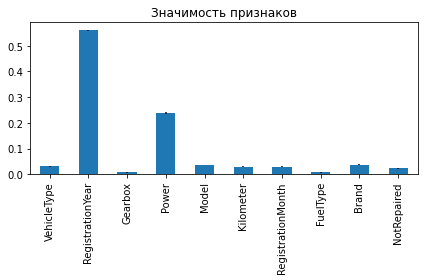

In [38]:

feature_names = features_train.columns
forest = RandomForestRegressor(random_state=0)
forest.fit(features_train, target_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Значимость признаков")
fig.tight_layout()

Наиболее важный признак для прогнозирования стоимости авто - дата регистрации автомобиля, возможно для разных возрастов - разное ценообразование, попробуем ввести категорию - тип возраста.

In [39]:
df['RegistrationYear'].describe()

count    302242.00000
mean       2002.45266
std           6.21343
min        1961.00000
25%        1999.00000
50%        2003.00000
75%        2007.00000
max        2015.00000
Name: RegistrationYear, dtype: float64

In [40]:
# добавим столбец с категоризацией
def category(year):
    if year < 1990:
        return 'ретро'
    if year < 2000 and year > 1990:
        return 'старая'
    if year < 2016 and year > 2000:
        return 'новая'
    
# создадим три новых датасета
df['age_type'] = df['RegistrationYear'].apply(category)
new = df.loc[df['age_type'] == 'новая']
old = df.loc[df['age_type'] == 'старая']
retro = df.loc[df['age_type'] == 'ретро']

# разделим признаки и целевой признак
def data(data):
    data = data.drop(['age_type'], axis=1)
    features = data.drop(['Price'], axis=1)
    target = data['Price']
    
    return features, target

new_features, new_target = data(new)
old_features, old_target = data(old)
retro_features, retro_target = data(retro)

Проверим значимость признаков при моделировании для новых, старых и ретро моделей машин.

In [41]:
# создадим серии с значимостью признаков
names = new_features.columns

def significance(features, target):
    forest = RandomForestRegressor(random_state=0)
    forest.fit(features, target)
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=names)
    
    return forest_importances

# применим к трем категориям
forest_importances_new = significance(new_features, new_target)
forest_importances_old = significance(old_features, old_target)
forest_importances_retro = significance(retro_features, retro_target)

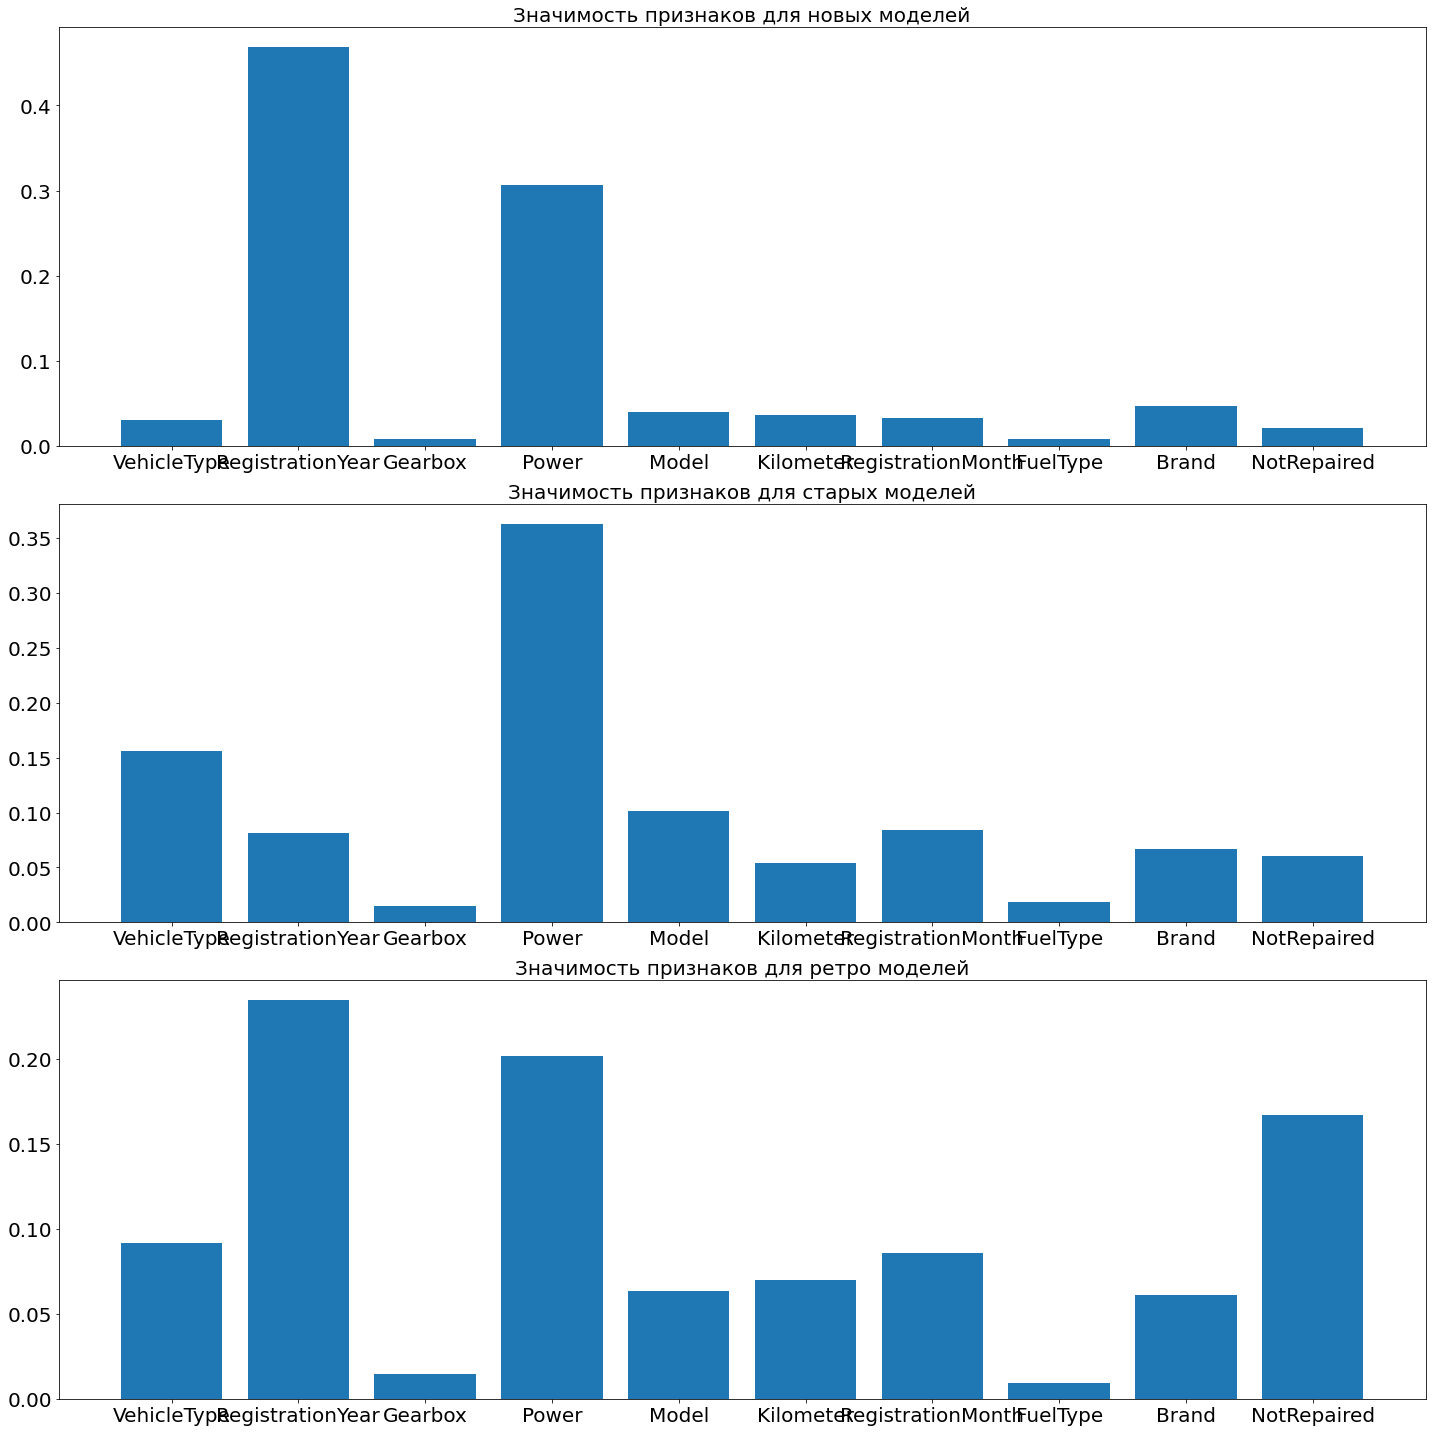

In [42]:
# визуализируем
fig = plt.figure(figsize=(20, 20))

ax_1 = fig.add_subplot(3, 1, 1)
ax_2 = fig.add_subplot(3, 1, 2)
ax_3 = fig.add_subplot(3, 1, 3)

ax_1.bar(forest_importances_new.index, forest_importances_new)
ax_1.set_title("Значимость признаков для новых моделей", fontsize=20)
ax_1.tick_params(labelsize=20)

ax_2.bar(forest_importances_old.index, forest_importances_old)
ax_2.set_title("Значимость признаков для старых моделей", fontsize=20)
ax_2.tick_params(labelsize=20)

ax_3.bar(forest_importances_retro.index, forest_importances_retro)
ax_3.set_title("Значимость признаков для ретро моделей", fontsize=20)
ax_3.tick_params(labelsize=20)

fig.tight_layout()

Действительно для разных возрастных категорий машин наиболее значимые признаки разные. При обучении модели необходимо учитывать возраст машины. Для новых машин наиболее значимые признаки - это год регистрации авто, а также его мощность. Для старых моделей наиболее важна мощность, а для ретро авто - год регистрации, мощность и наличие ремонта.

Проверим, изменилось ли качество предсказания для категоризированных данных.

In [43]:
# new_features, new_target, old_features, old_target, retro_features, retro_target

best_gbm_model.fit(new_features, new_target)
predictions_gbm = best_gbm_model.predict(new_features)

print ('Средняя ошибка градиентного бустинга для категории новых машин: ', 
       round(mean_squared_error(new_target, predictions_gbm) ** 0.5))


Средняя ошибка градиентного бустинга для категории новых машин:  1269


In [44]:
best_gbm_model.fit(old_features, old_target)
predictions_gbm = best_gbm_model.predict(old_features)

print ('Средняя ошибка градиентного бустинга для категории старых машин: ', 
       round(mean_squared_error(old_target, predictions_gbm) ** 0.5))


Средняя ошибка градиентного бустинга для категории старых машин:  783


In [45]:
best_gbm_model.fit(retro_features, retro_target)
predictions_gbm = best_gbm_model.predict(retro_features)

print ('Средняя ошибка градиентного бустинга для категории ретро машин: ', 
       round(mean_squared_error(retro_target, predictions_gbm) ** 0.5))

Средняя ошибка градиентного бустинга для категории ретро машин:  1175


Метрики модели улучшились - соответственно, ценообразование разное, чтобы модель лучше предсказывала стоимость авто, необходимо учитывать, что для разных возрастных категорий машин - нужны разные модели.

**Вывод:**

Исходя из критериев заказчика, наиболее подходящая модель для определения стоимости автомобиля - модель градиентного бустинга. Данная модель быстрее других обучается, однако на предсказания тратит больше времени. Модель имеет наименьшую среднюю ошибку предсказаний. Для более точного прогнозирования стоимости авто, данные необходимо категоризировать по возрасту машин, для разных категорий - разное ценообразование.

**Тестирование модели**

Проверим модель на тестовой выборке.

In [46]:
best_gbm_model.fit(features_train, target_train)
prediction = best_gbm_model.predict(features_test)

print ('Качество модели на тестовой выборке: ', round(mean_squared_error(target_test, prediction) ** 0.5 ))

Качество модели на тестовой выборке:  1485


Проверим модель на адекватность - сравним с константной моделью DummyRegressor.

In [47]:
model = DummyRegressor(strategy = 'mean')
model.fit(features_train, target_train)
prediction = model.predict(features_test)

print ('Качество модели на тестовой выборке: ', round(mean_squared_error(target_test, prediction) ** 0.5 ))

Качество модели на тестовой выборке:  4599


Модель градиентного бустинга показала себя с лучшей стороны, в отличии от дамми-модели.

**Вывод:**

Задача проекта - построить модель для определения стоимости автомобиля выполнена.

Выбрана наилучшая модель - LightGBM. Модель удовлетворяет требованиям заказчика - скорость обучения, скорость предсказаний, качество предсказаний.

В исследовании были выполнены следующие шаги:

Подготовлены данные:
* Очищены от неинформативных признаков
* Обработаны пропуски и аномалии в данных
* Подготовлены выборки
* Признаки стандартизированы и закодированы

Обучение модели:
* Обучено несколько моделей
* Оценено качество и скорость моделей и выбрана наиболее эффективная
* Лучшая модель протестирована
